<center><h1>Section 5-2A Output Graphics</h1></center>

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib widget
%matplotlib inline

In [2]:
# parameters cell
root_directory = os.path.dirname(os.path.dirname(os.getcwd()))
program_file = 'test-0.0.0-results5-2a.json'

In [3]:
# local module import
if os.path.join(root_directory, 'src') not in sys.path:
    sys.path.append(os.path.join(root_directory, 'src'))

from graphics_renderer import GraphicsRenderer

In [4]:
gr = GraphicsRenderer(program_file)

In [5]:
HTML("""
<style>
    .jp-RenderedImage {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
</style>
""")

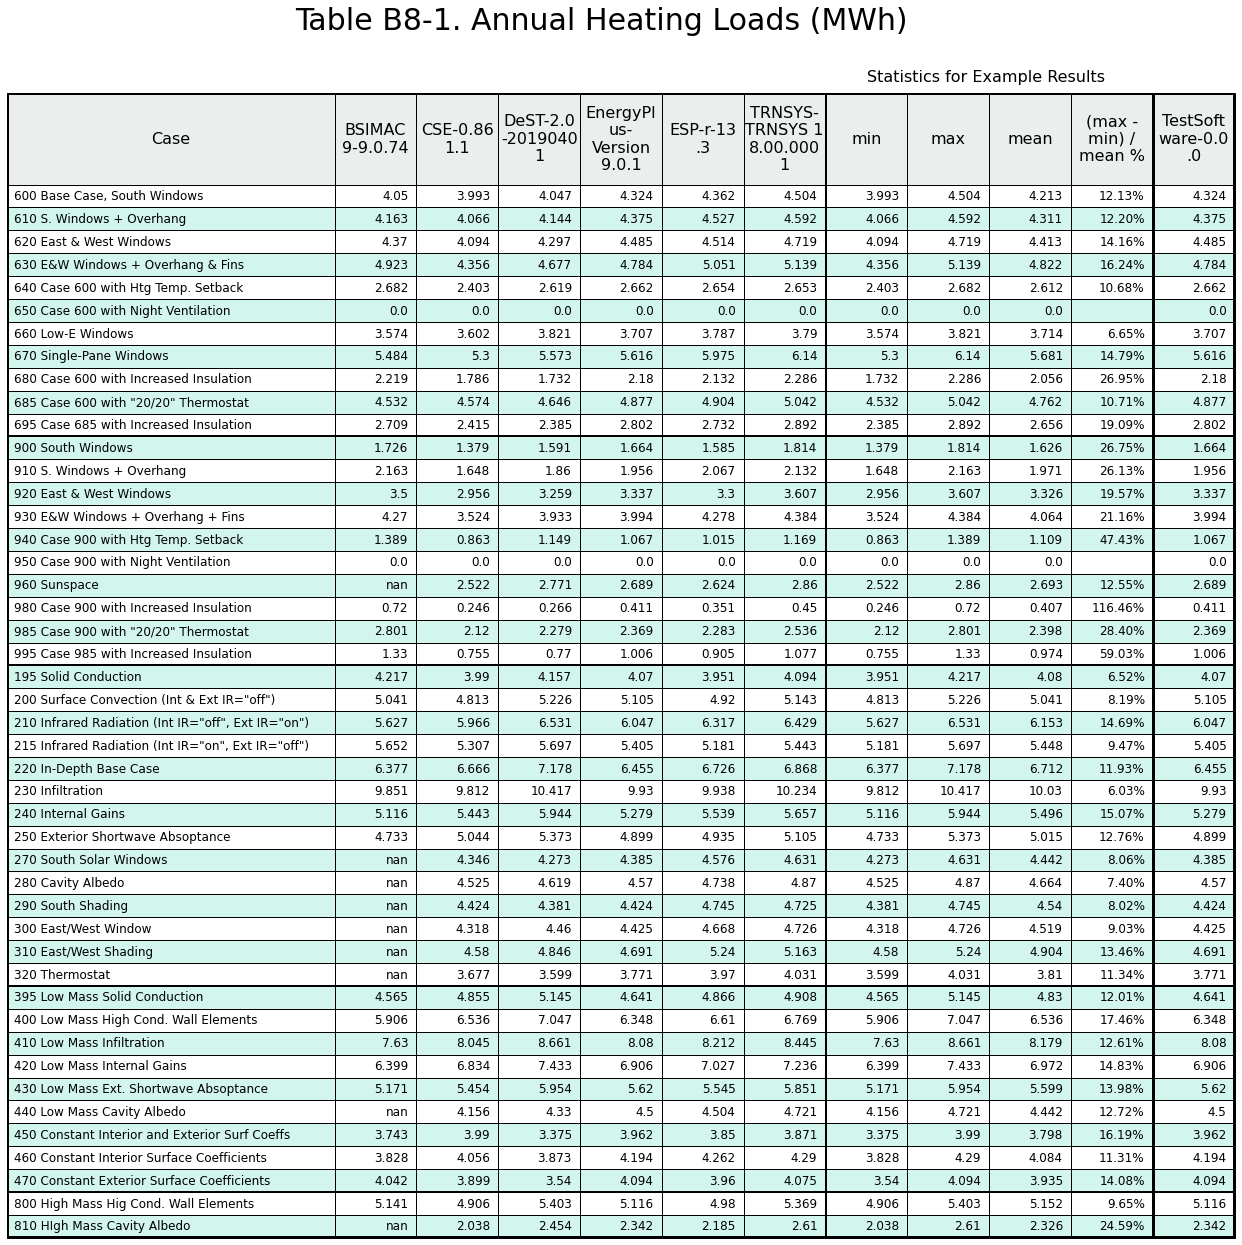

In [6]:
gr.render_section_5_2a_table_b_8_1()
plt.show();

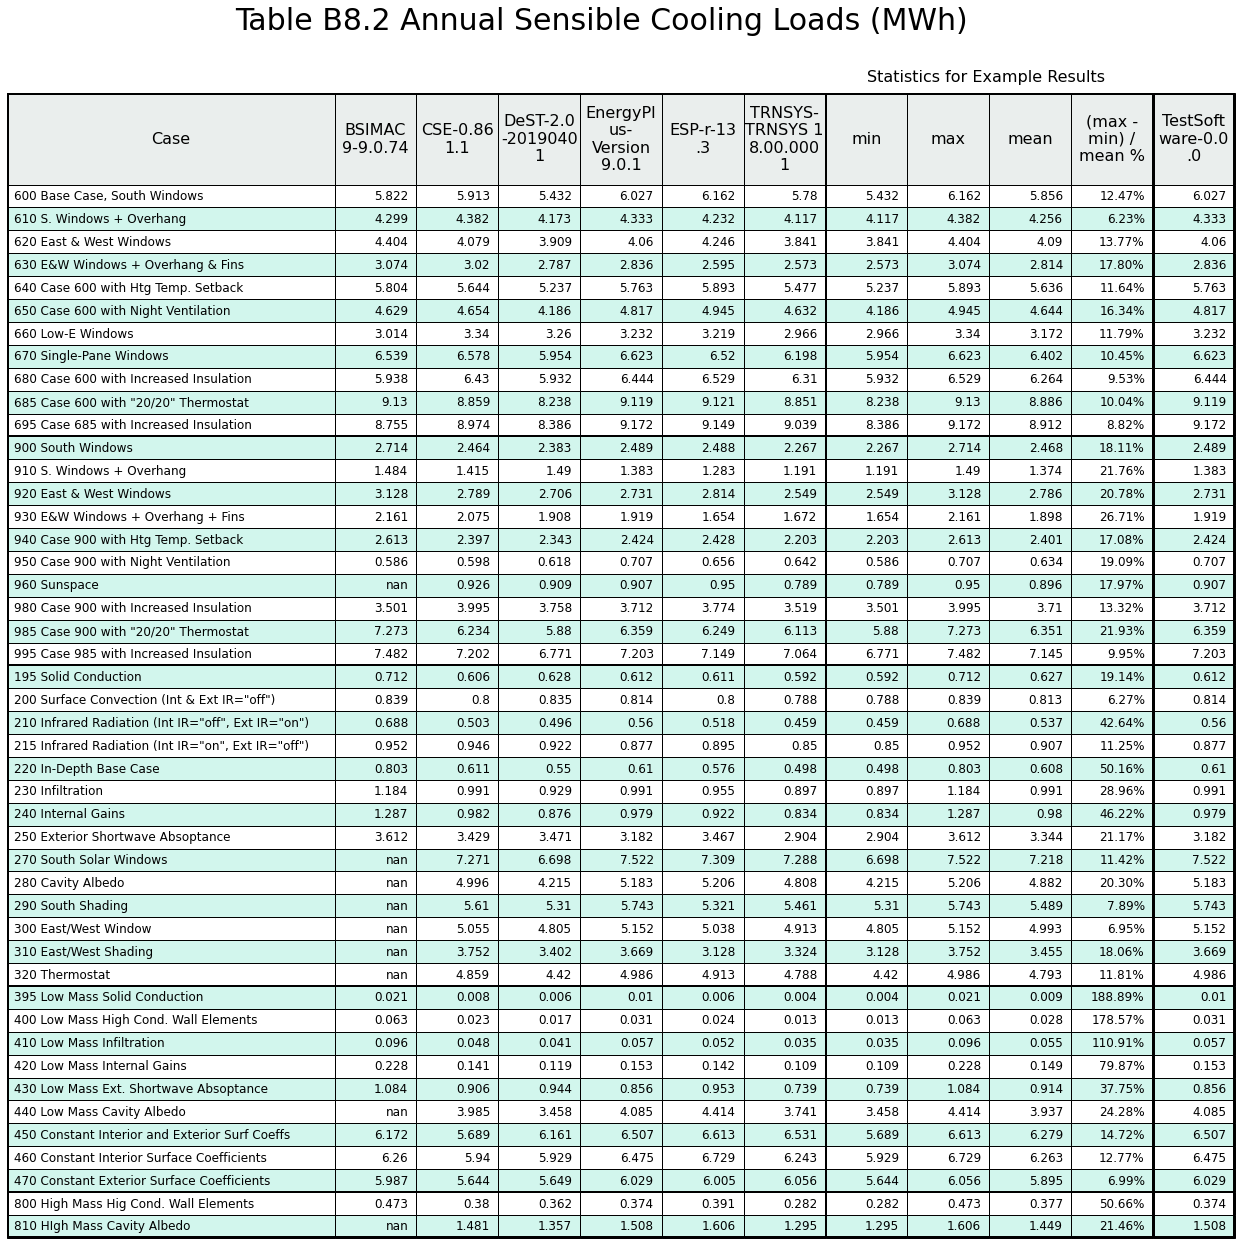

In [7]:
gr.render_section_5_2a_table_b_8_2()
plt.show();

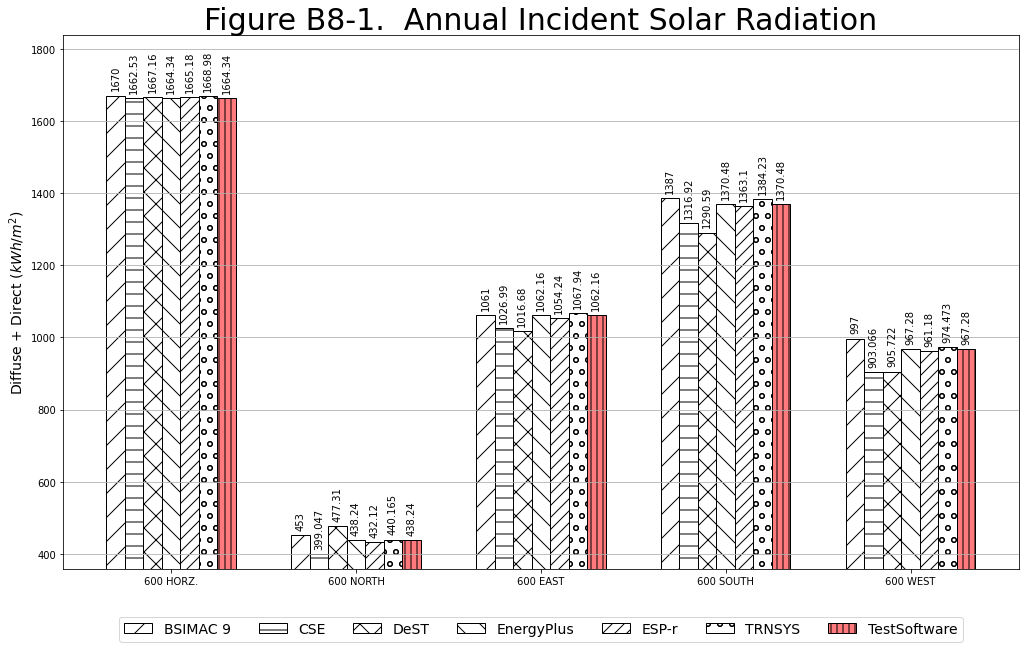

In [8]:
gr.render_section_5_2a_figure_b_8_1()
plt.show();

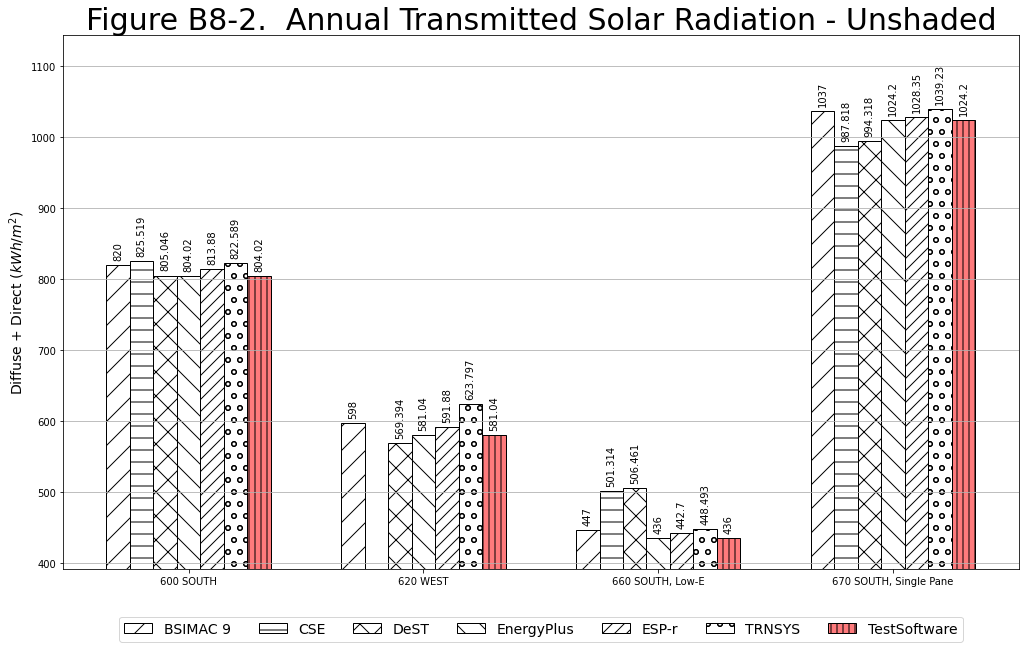

In [9]:
gr.render_section_5_2a_figure_b_8_2()
plt.show();

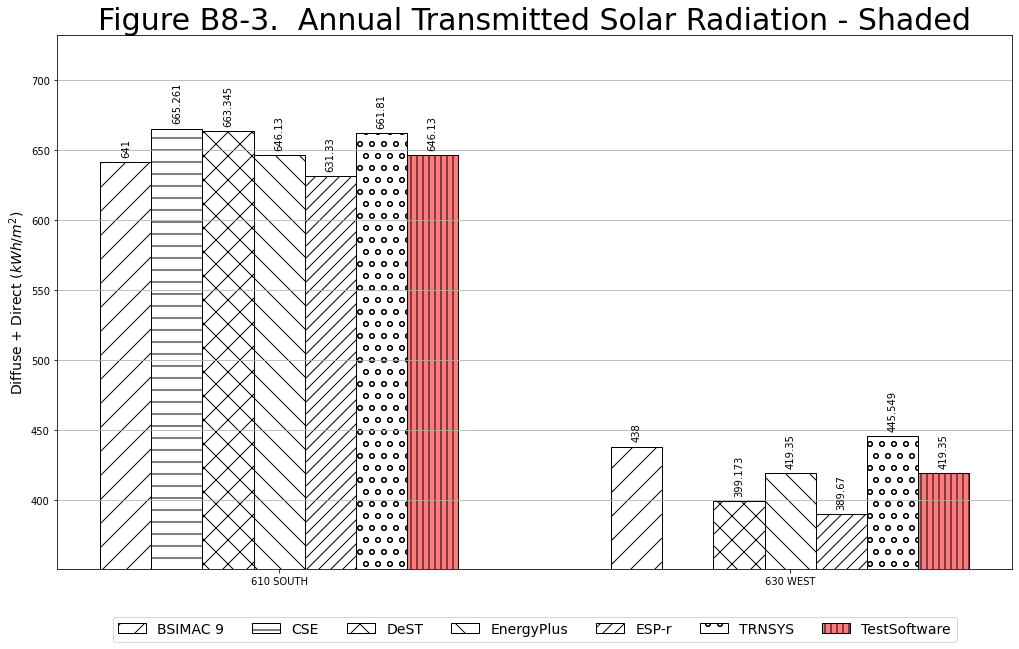

In [10]:
gr.render_section_5_2a_figure_b_8_3()
plt.show();

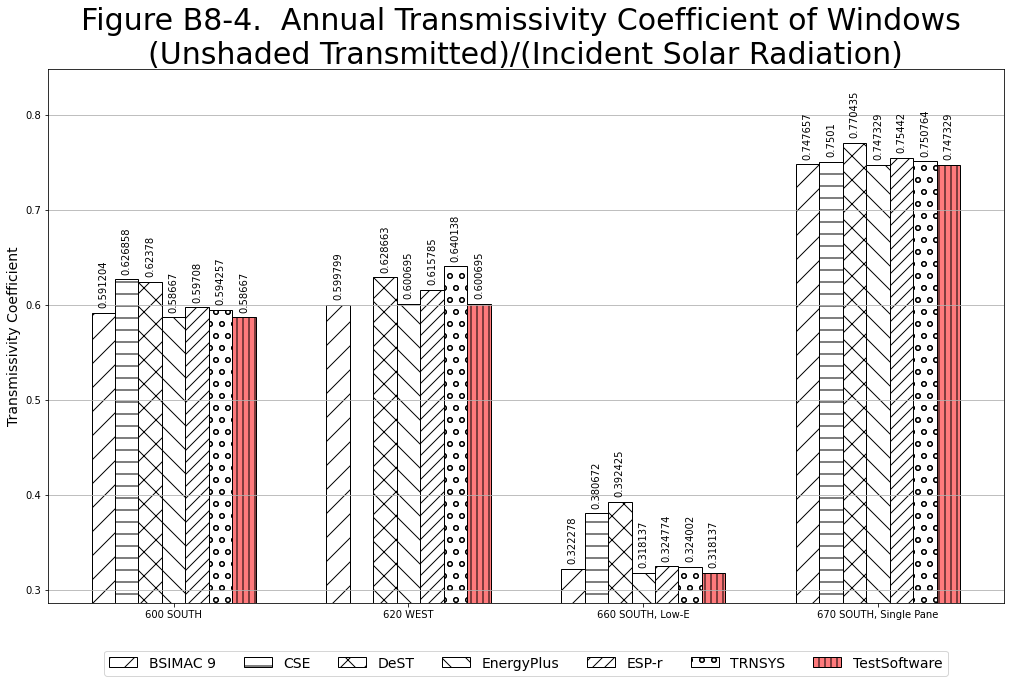

In [11]:
gr.render_section_5_2a_figure_b_8_4()
plt.show();

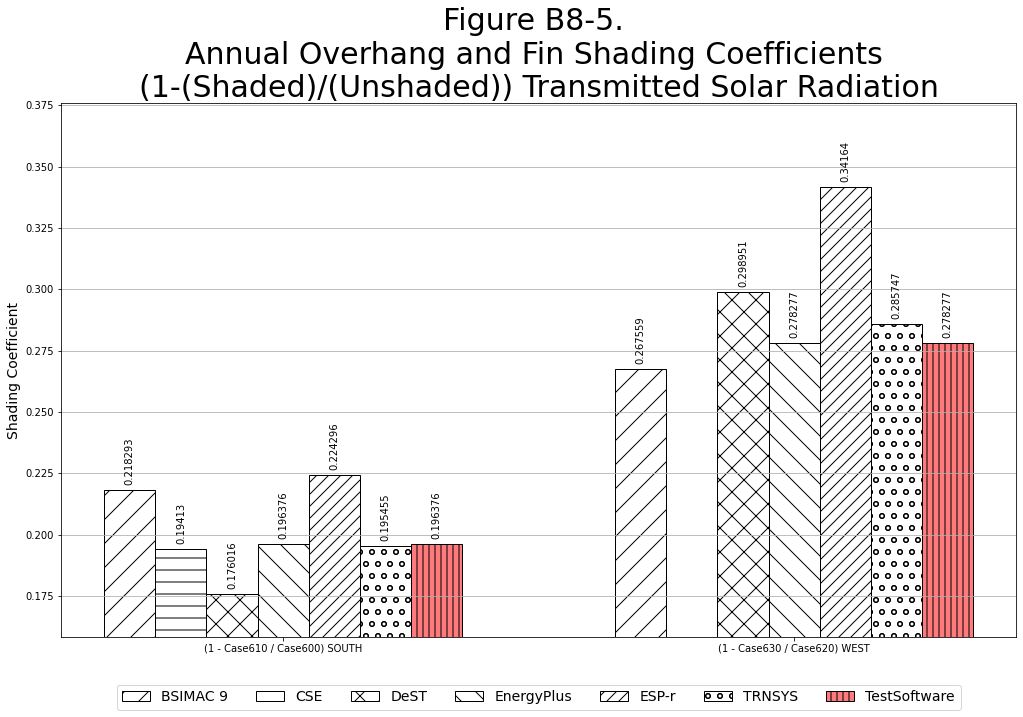

In [12]:
gr.render_section_5_2a_figure_b_8_5()
plt.show();

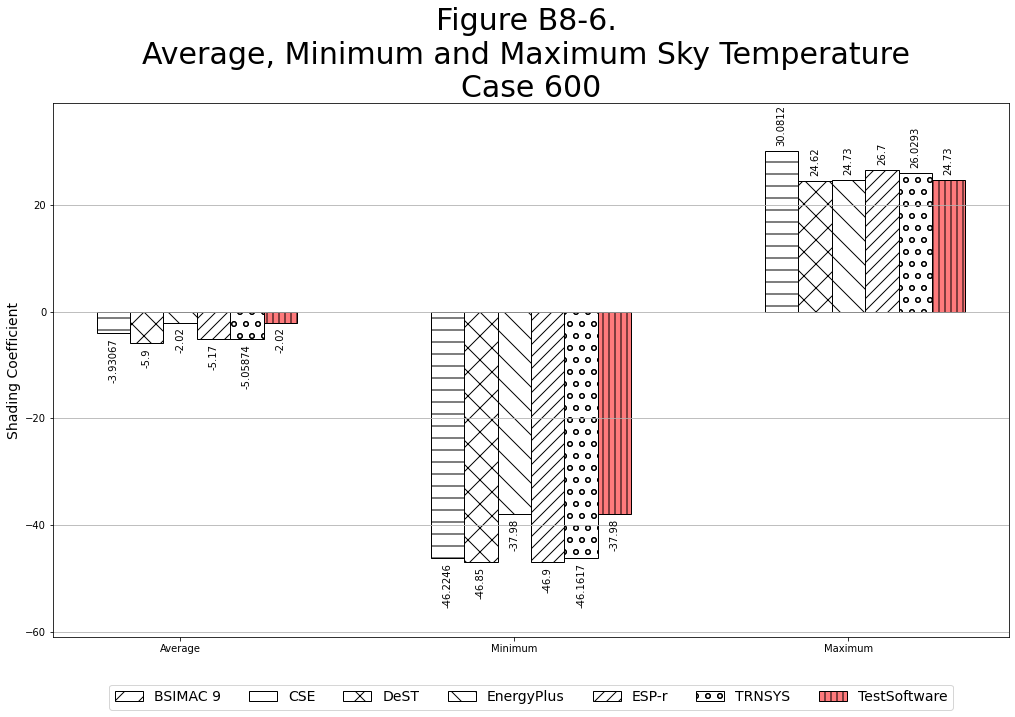

In [13]:
gr.render_section_5_2a_figure_b_8_6()
plt.show();

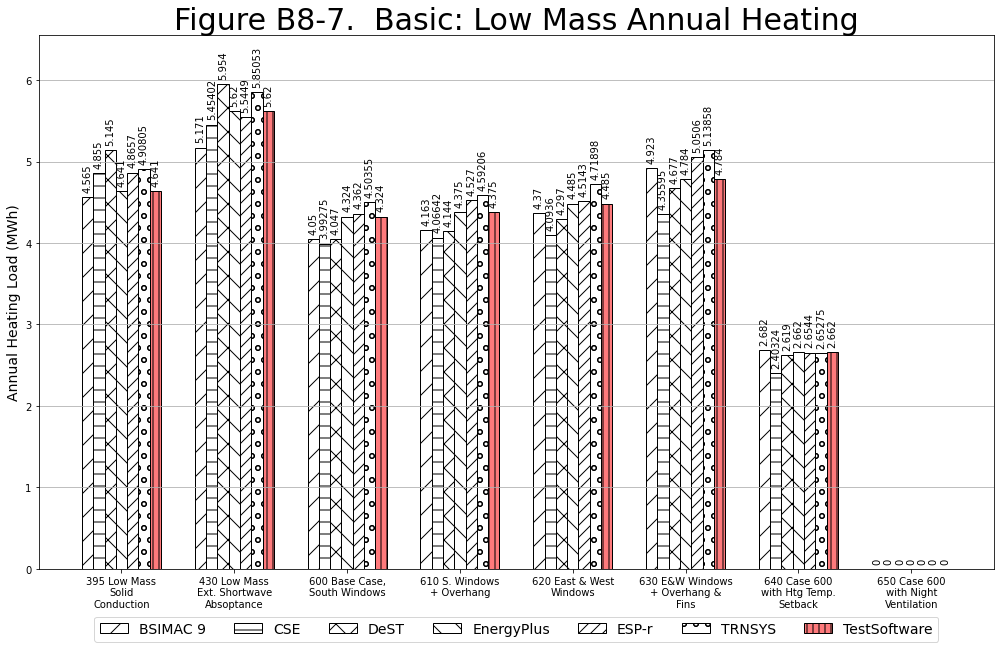

In [14]:
gr.render_section_5_2a_figure_b_8_7()
plt.show();

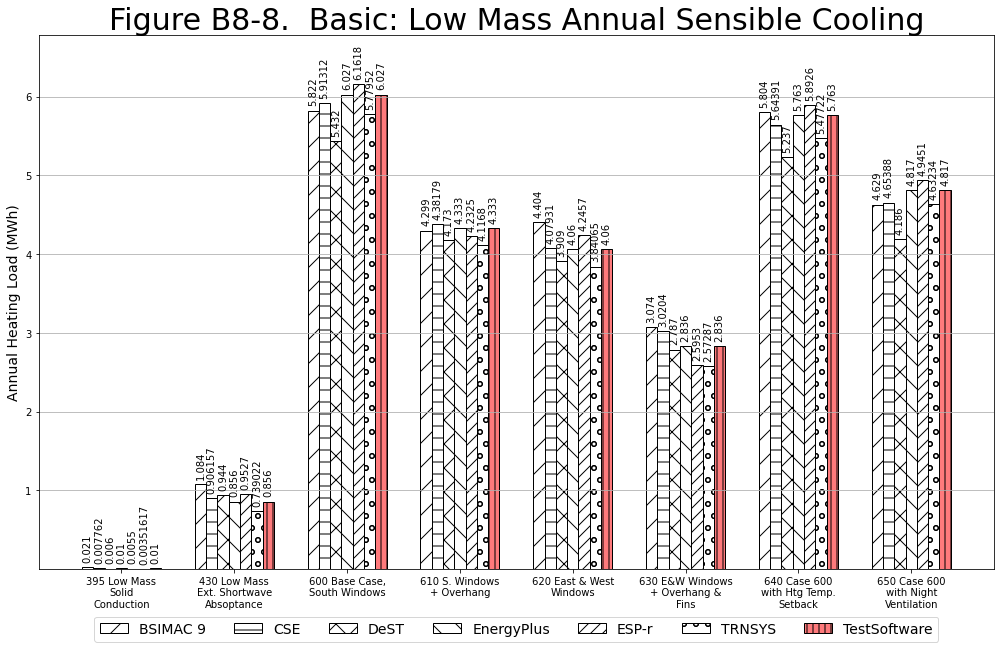

In [15]:
gr.render_section_5_2a_figure_b_8_8()
plt.show();

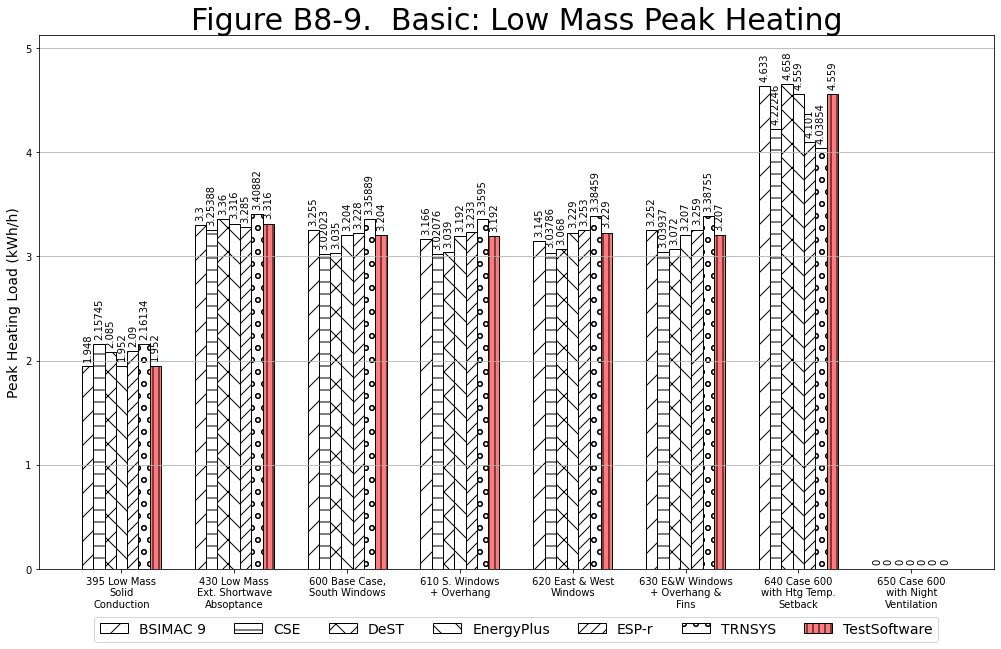

In [16]:
gr.render_section_5_2a_figure_b_8_9()
plt.show();

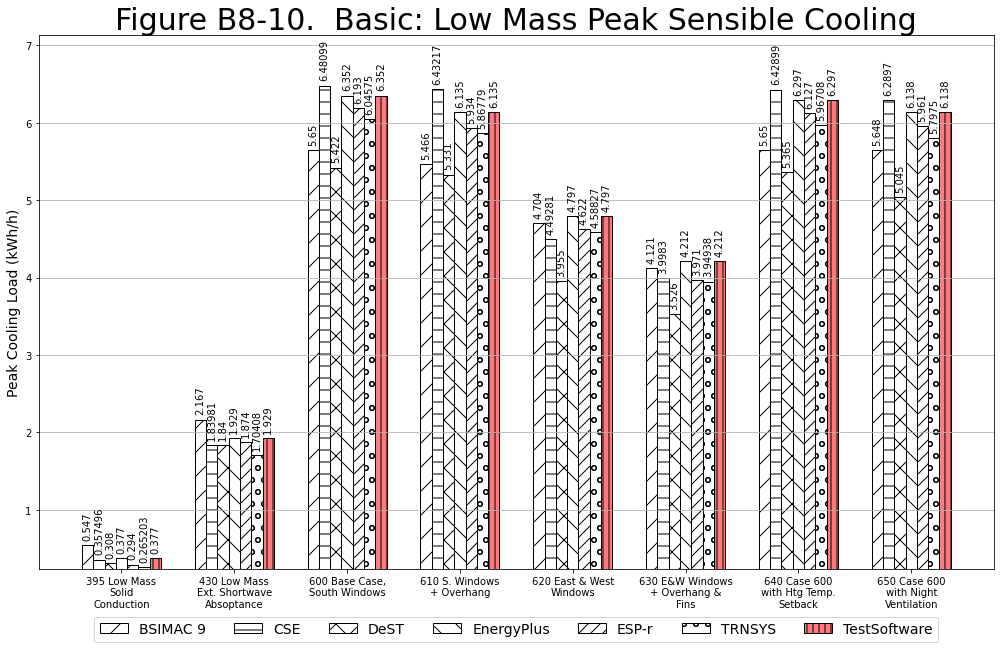

In [17]:
gr.render_section_5_2a_figure_b_8_10()
plt.show();

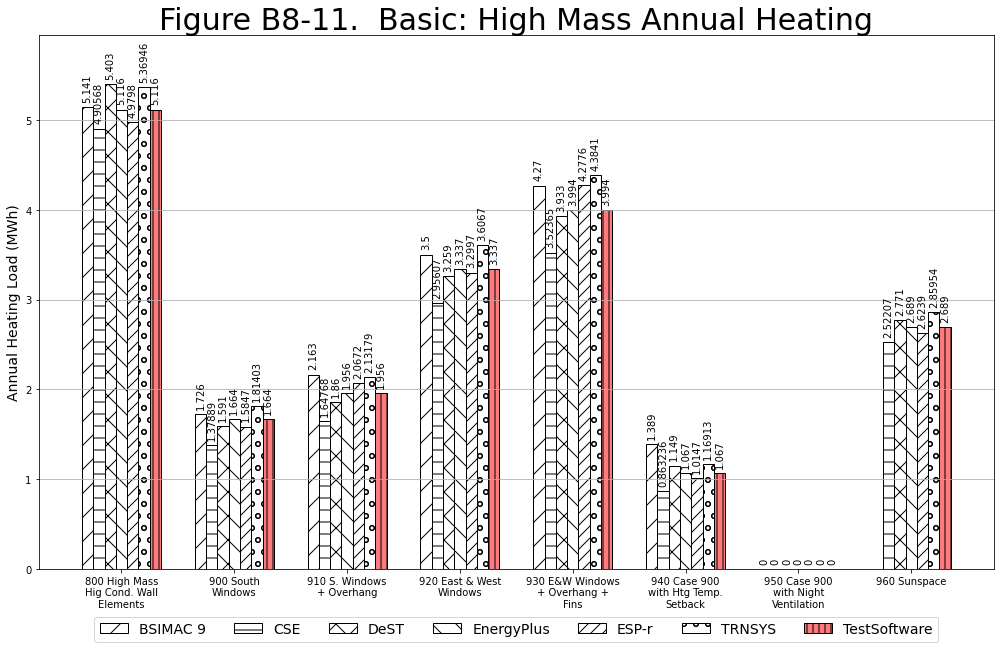

In [18]:
gr.render_section_5_2a_figure_b_8_11()
plt.show();

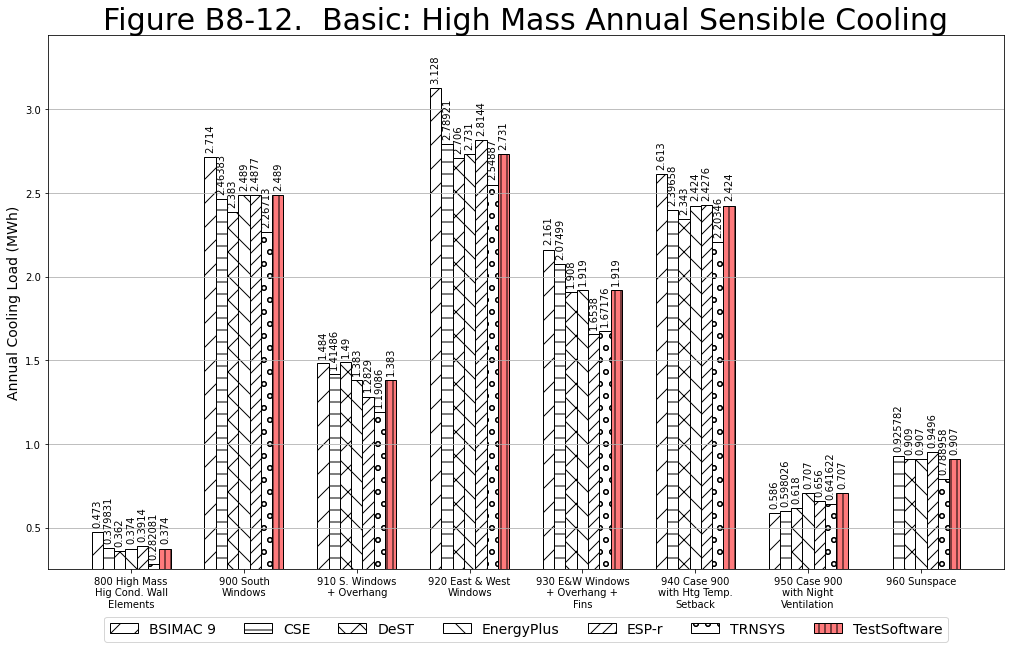

In [19]:
gr.render_section_5_2a_figure_b_8_12()
plt.show();

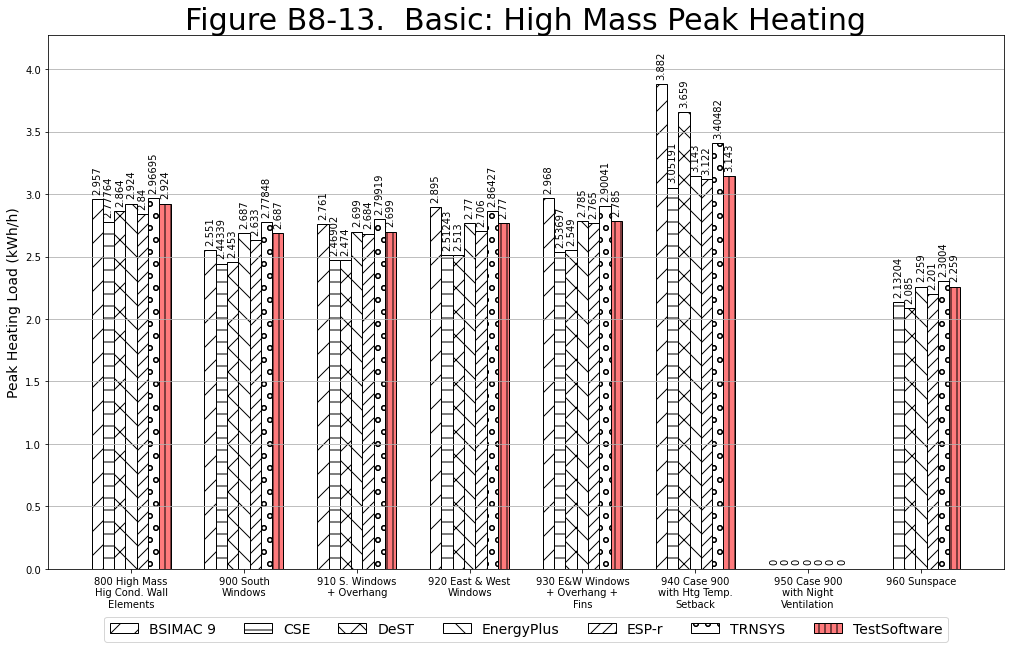

In [20]:
gr.render_section_5_2a_figure_b_8_13()
plt.show();

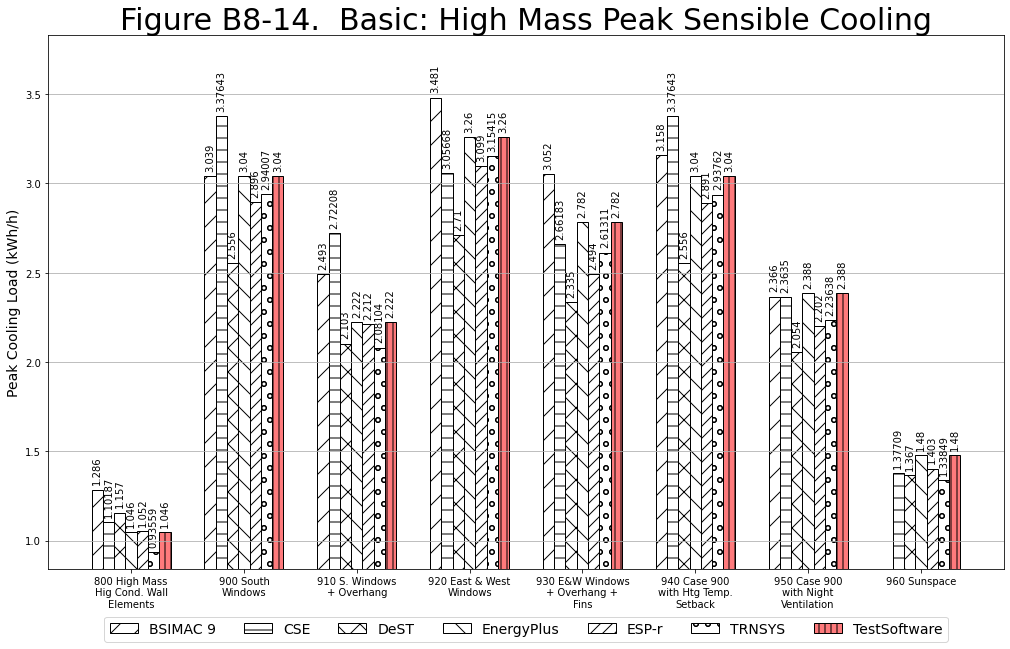

In [21]:
gr.render_section_5_2a_figure_b_8_14()
plt.show();

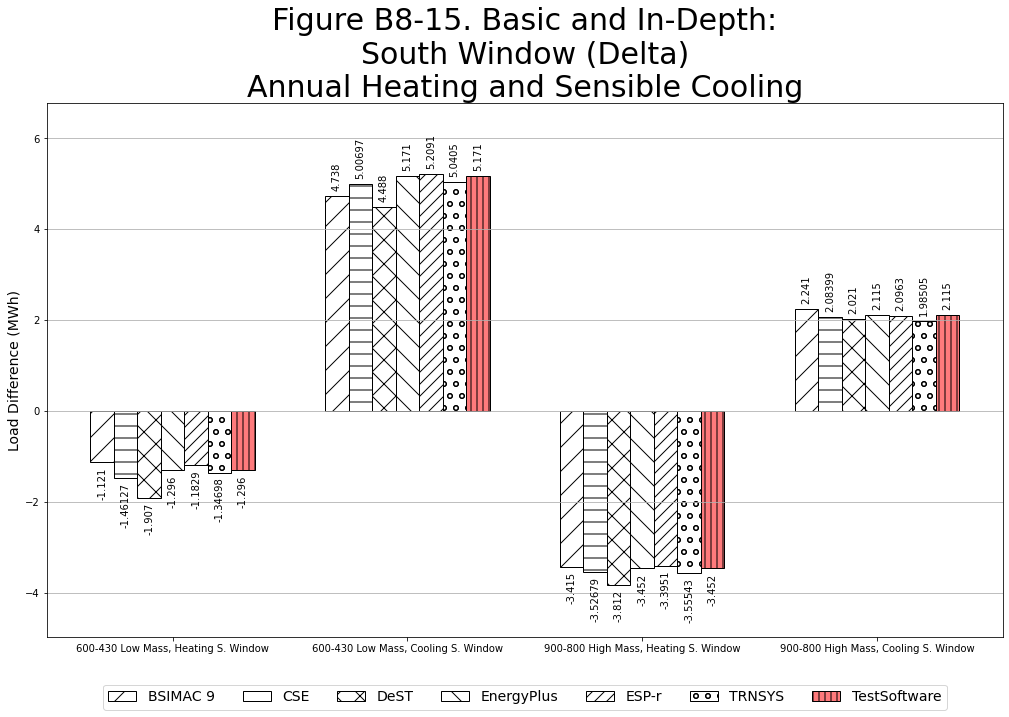

In [22]:
gr.render_section_5_2a_figure_b_8_15()
plt.show();

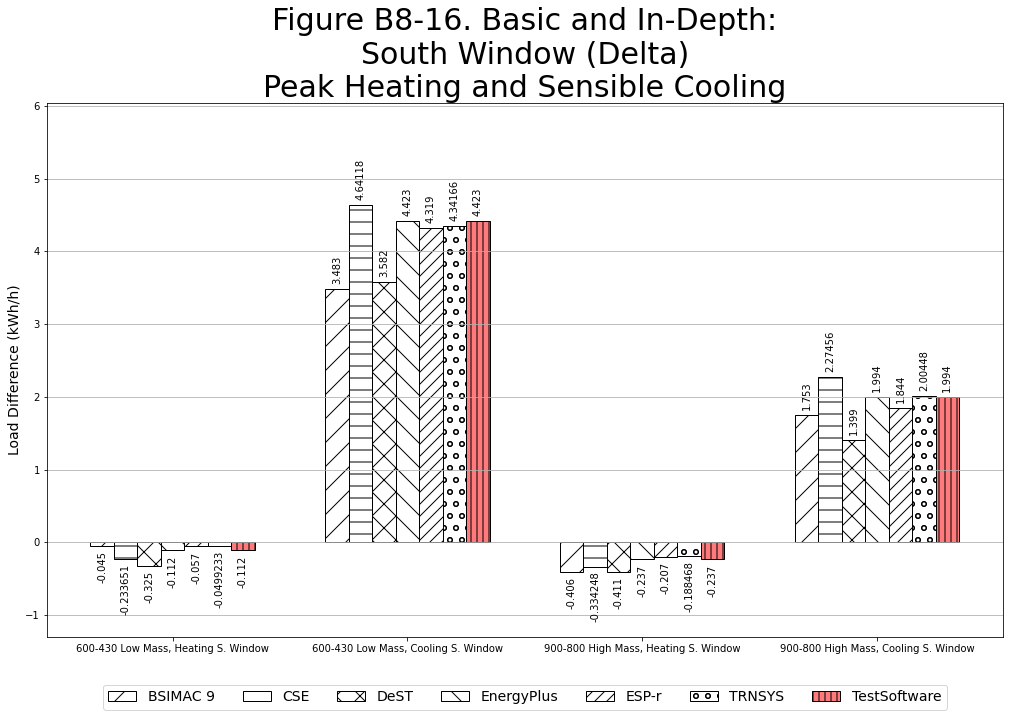

In [23]:
gr.render_section_5_2a_figure_b_8_16()
plt.show();

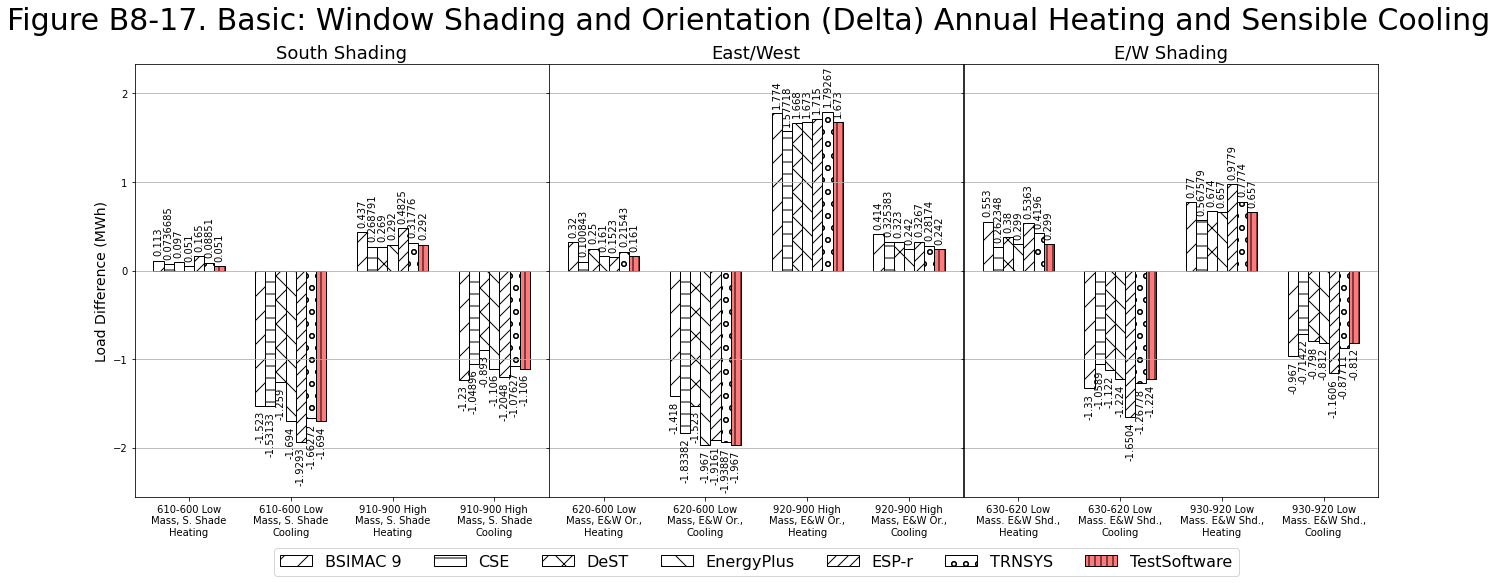

In [24]:
gr.render_section_5_2a_figure_b8_17()
plt.show();

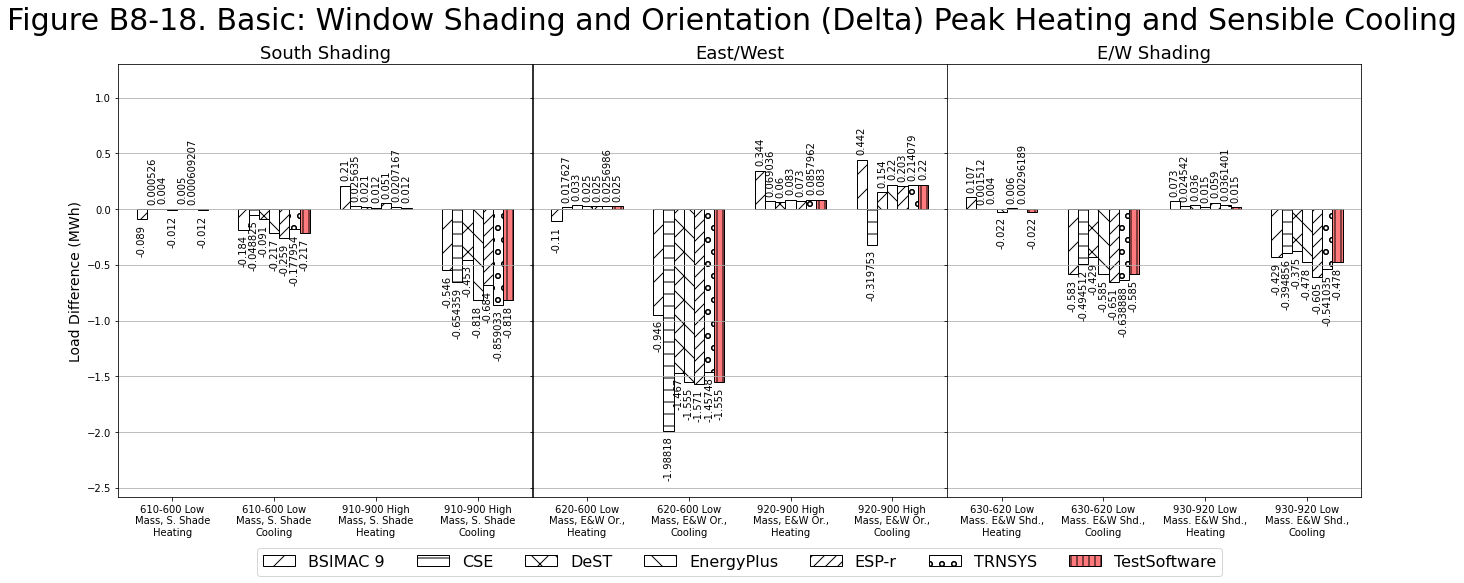

In [25]:
gr.render_section_5_2a_figure_b8_18()
plt.show();

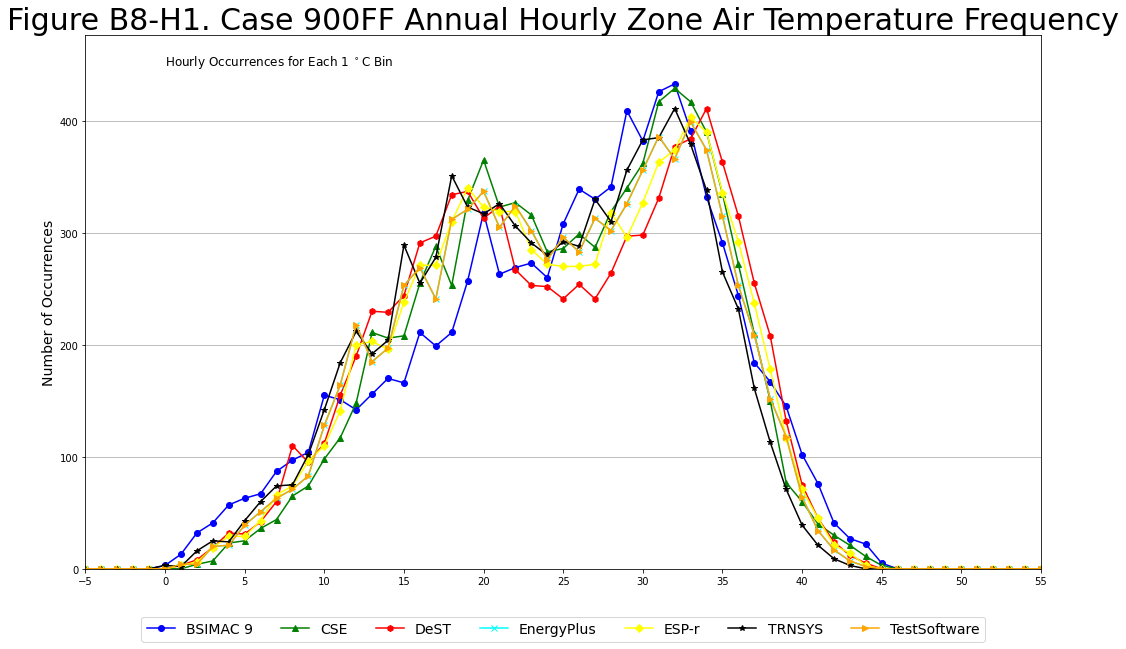

In [26]:
gr.render_section_5_2a_figure_b8_h1()
plt.show();

In [27]:
# Example Dataframe storage object
gr.df_data

{'conditioned_zone_loads_non_free_float':                                              195                     \
                               annual_cooling_MWh annual_heating_MWh   
 program_name                                                          
 bsimac-9.9.0.7.4-results5-2a            0.712000           4.217000   
 cse-0.861.1-results5-2a                 0.605525           3.990079   
 dest-2.0.20190401-results5-2a           0.628000           4.157000   
 energyplus-9.0.1-results5-2a            0.612000           4.070000   
 esp-r-13.3-results5-2a                  0.611000           3.950900   
 trnsys-18.00.0001-results5-2a           0.591534           4.093940   
 test-0.0.0-results5-2a                  0.612000           4.070000   
 
                                                                   \
                               peak_cooling_day peak_cooling_hour   
 program_name                                                       
 bsimac-9.9.0.7.4-results5-2a 

In [28]:
# Example dataframe display
display(gr.df_data['conditioned_zone_loads_non_free_float'])

195                     \
                              annual_cooling_MWh annual_heating_MWh   
program_name                                                          
bsimac-9.9.0.7.4-results5-2a            0.712000           4.217000   
cse-0.861.1-results5-2a                 0.605525           3.990079   
dest-2.0.20190401-results5-2a           0.628000           4.157000   
energyplus-9.0.1-results5-2a            0.612000           4.070000   
esp-r-13.3-results5-2a                  0.611000           3.950900   
trnsys-18.00.0001-results5-2a           0.591534           4.093940   
test-0.0.0-results5-2a                  0.612000           4.070000   

                                                                  \
                              peak_cooling_day peak_cooling_hour   
program_name                                                       
bsimac-9.9.0.7.4-results5-2a              26.0              17.0   
cse-0.861.1-results5-2a                   26.0              17.0   
dest-2.0.20190401-results5-2a             26.0              16.0   
energyplus-9.0.1-results5-2a              26.0              17.0   
esp-r-13.3-results5-2a                    26.0              17.0   
trnsys-18.00.0001-results5-2a             26.0              17.0   
test-0.0.0-results5-2a                    26.0              17.0   

                                                                  \
                              peak_cooling_kW peak_cooling_month   
program_name                                                       
bsimac-9.9.0.7.4-results5-2a         1.118000                Jun   
cse-0.861.1-results5-2a              0.994253                Jun   
dest-2.0.20190401-results5-2a        0.973000                Jun   
energyplus-9.0.1-results5-2a         1.041000                Jun   
esp-r-13.3-results5-2a               0.944000                Jun   
trnsys-18.00.0001-results5-2a        0.993513                Jun   
test-0.0.0-results5-2a               1.041000                Jun   

                                                                  \
                              peak_heating_day peak_heating_hour   
program_name                                                       
bsimac-9.9.0.7.4-results5-2a              31.0              24.0   
cse-0.861.1-results5-2a                    1.0               1.0   
dest-2.0.20190401-results5-2a              1.0               0.0   
energyplus-9.0.1-results5-2a              31.0              24.0   
esp-r-13.3-results5-2a                     1.0               1.0   
trnsys-18.00.0001-results5-2a              1.0               1.0   
test-0.0.0-results5-2a                    31.0              24.0   

                                                                  ...  \
                              peak_heating_kW peak_heating_month  ...   
program_name                                                      ...   
bsimac-9.9.0.7.4-results5-2a         1.802000                Dec  ...   
cse-0.861.1-results5-2a              1.790699                Jan  ...   
dest-2.0.20190401-results5-2a        1.799000                Jan  ...   
energyplus-9.0.1-results5-2a         1.794000                Dec  ...   
esp-r-13.3-results5-2a               1.802000                Jan  ...   
trnsys-18.00.0001-results5-2a        1.795922                Jan  ...   
test-0.0.0-results5-2a               1.794000                Dec  ...   

                                             995                     \
                              annual_cooling_MWh annual_heating_MWh   
program_name                                                          
bsimac-9.9.0.7.4-results5-2a            7.482000           1.330000   
cse-0.861.1-results5-2a                 7.202152           0.755182   
dest-2.0.20190401-results5-2a           6.771000           0.770000   
energyplus-9.0.1-results5-2a            7.203000           1.006000   
esp-r-13.3-results5-2a                  7.148800           0.90

In [29]:
# Example json storage object
from pprint import pprint
pprint(gr.json_data['bsimac-9.9.0.7.4-results5-2a'])

{'conditioned_zone_loads_non_free_float': {'195': {'annual_cooling_MWh': 0.712,
                                                   'annual_heating_MWh': 4.217,
                                                   'peak_cooling_day': 26.0,
                                                   'peak_cooling_hour': 17.0,
                                                   'peak_cooling_kW': 1.118,
                                                   'peak_cooling_month': 'Jun',
                                                   'peak_heating_day': 31.0,
                                                   'peak_heating_hour': 24.0,
                                                   'peak_heating_kW': 1.802,
                                                   'peak_heating_month': 'Dec'},
                                           '200': {'annual_cooling_MWh': 0.839,
                                                   'annual_heating_MWh': 5.041,
                                                   'pea